In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None

## Helper functions

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    """
    This is a function to save the last plot to a file.
    
    Parameters:
    fig_id (string) name of the saved file
    tight_layout (boolean) sets layout type. Defaults to True
    
    Returns:
    None
    """
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def histplot(data, bins=20, title=''):
    """
    Creates a plot using the distplot method in seaborn
    
    Parameters:
    data (pd.Series) data to create histogram from
    bins (int) the number of bins to group data by
    title (string) title given to the plot
    
    Returns:
    sns.distplot
    """
    return sns.distplot(data, bins=bins).set_title(title);

In [4]:
def valueCountsBarPlot(data, dropna=False, title=''):
    """
    Uses the results of a value count to create a plot
    
    Parameters:
    data (pd.Series) data to be counted
    dropna (boolean) where to drop nans from the data
    title (string) what to label the returned plot
    
    Returns:
    plot
    """
    return pd.DataFrame(data.value_counts(dropna=dropna).sort_index()).plot(kind='bar').set_title(title);

## Business objectives

There are a number of questions that can be asked of this data but I am just going to answer 3 simple one.

<ol>
    <li>When is it cheapest to visit Boston?</li>
    <li>What features lead to a higher prices?</li>
    <li>What features lead to a higher prices?</li>
</ol>

Each question will require data understanding and processing. The last question will require the most amount of work as I wish to use a linear model to find the importance of the features.

## Loading Data

The data has already been collected and processed into useable csv files by AirBnB. We are just going to load the data using pandas into a DataFrame object.

In [5]:
calendar = pd.read_csv('./Data/calendar.csv', parse_dates=['date'])
listings = pd.read_csv('./Data/listings.csv', parse_dates=['last_scraped', 'host_since', 'calendar_last_scraped','first_review', 'last_review'])
reviews = pd.read_csv('./Data/reviews.csv', parse_dates=['date'])

## General Data overview

Here I am just going to quickly look over the data making sure that it has loaded corrected and checking for useful stats.

In [6]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [7]:
# calculating the unique number of listings
calendar.listing_id.nunique()

3585

In [8]:
calendar.describe(include='all')

,listing_id,date,available,price
count,1.308890e+06,1308890,1308890,643037
unique,NaN,365,2,1246
top,NaN,2016-12-27 00:00:00,f,$150.00
freq,NaN,3586,665853,20752
first,NaN,2016-09-06 00:00:00,NaN,NaN
last,NaN,2017-09-05 00:00:00,NaN,NaN
mean,8.442118e+06,NaN,NaN,NaN
std,4.500149e+06,NaN,NaN,NaN
min,3.353000e+03,NaN,NaN,NaN
25%,4.679319e+06,NaN,NaN,NaN


This data shows all the times and the prices that a listing was made on AirBnB runing from 2016-09-06 to 2017-09-05. We can use this data to help us anwser our first question.

In [9]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [10]:
# checking that the data is unique at an id level
listings.id.duplicated().any()

False

In [11]:
listings.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3585,3.585000e+03,3585,3585,3442,2528,3585,3585,2170,1610,2295,2096,2031,2393,2986,2986,3585,2986,3.585000e+03,3585,3585,3585,3574,2276,3114,3114,3114,3585,3585,3585,3246,3585.000000,3585.000000,3585,3585,3585,3585,3042,3585,0.0,3583,3585,3547,3571,3585,3585,3585,3585.000000,3585.000000,3585,3582,3585,3585.000000,3571.000000,3575.000000,3576.000000,3585,3585,56.000000,3585,892,888,1342,2478,3585.000000,3585,3585.000000,3.585000e+03,3585,0.0,3585.00000,3585.000000,3585.000000,3585.000000,3585,3585.000000,2829,2829,2772.000000,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585,0.0,0.0,3585,3585,3585,3585,3585.000000,2829.000000
unique,NaN,3585,NaN,1,3504,3113,2268,3423,1,1728,1269,1859,1762,1617,1928,2986,2986,3585,2986,NaN,2181,1334,1281,176,1240,4,52,72,2,2174,2174,53,NaN,NaN,83,2,2,1239,30,25,NaN,38,1,43,4,39,1,1,NaN,NaN,2,13,3,NaN,NaN,NaN,NaN,5,3092,NaN,324,243,288,54,79,NaN,51,NaN,NaN,38,NaN,NaN,NaN,NaN,NaN,1,NaN,975,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,4,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/14864858,NaN,2016-09-07 00:00:00,Lux 2BR by Fenway w/WiFi,"The unit is stylishly designed for comfort, va...",The studio's kitchenette comes equipped with a...,Studio offers the luxury of home furnishings w...,none,Conveniently bordering the neighborhoods of th...,Although we do not allow pets in our apartment...,"These newly constructed, luxury apartments epi...","You have access to the entire apartment, and a...",Need more towels? A restaurant recommendation?...,House Rules 1. Check-in is 4 pm local time. If...,https://a2.muscache.com/im/pictures/b7fb9851-c...,https://a2.muscache.com/im/pictures/bd58b9a0-8...,https://a1.muscache.com/im/pictures/61656193/2...,https://a1.muscache.com/im/pictures/74898595/4...,NaN,https://www.airbnb.com/users/show/30283594,Kara,2015-03-30 00:00:00,"Boston, Massachusetts, United States",ABOUT US:\r\n\r\nSeamlessTransition is a full-...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/30283594/prof...,https://a2.muscache.com/im/users/30283594/prof...,Allston-Brighton,NaN,NaN,"['email', 'phone', 'reviews', 'jumio']",t,t,"Boylston Street, Boston, MA 02215, United States",Allston-Brighton,Jamaica Plain,NaN,Boston,MA,02116,Boston,"Boston, MA",US,United States,NaN,NaN,t,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,{},NaN,$150.00,"$1,000.00","$3,500.00",$100.00,$100.00,NaN,$0.00,NaN,NaN,today,NaN,NaN,NaN,NaN,NaN,2016-09-06 00:00:00,NaN,2016-04-05 00:00:00,2016-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,strict,f,f,NaN,NaN
freq,NaN

This data shows us details about each listing in the Boston area. It contains many intersting features that we will be able to use. We will be able to use this data to anwser our second and third questions.

In [12]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [13]:
reviews.describe(include='all')

,listing_id,id,date,reviewer_id,reviewer_name,comments
count,6.827500e+04,6.827500e+04,68275,6.827500e+04,68275,68222
unique,NaN,NaN,2045,NaN,14775,67311
top,NaN,NaN,2016-04-19 00:00:00,NaN,David,The host canceled this reservation the day bef...
freq,NaN,NaN,342,NaN,654,112
first,NaN,NaN,2009-03-21 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2016-09-06 00:00:00,NaN,NaN,NaN
mean,4.759910e+06,5.246516e+07,NaN,2.802389e+07,NaN,NaN
std,3.788990e+06,2.790991e+07,NaN,2.234097e+07,NaN,NaN
min,3.353000e+03,1.021000e+03,NaN,1.430000e+02,NaN,NaN
25%,1.458081e+06,3.010420e+07,NaN,9.001346e+06,NaN,NaN


The reviews data is also very interesting and can be used for different types of sentiment and topic analysis. However it won't be of much use in answering our three questions.

## When is it cheapest to visit Boston?

#### Data preperation

In [14]:
# Only the available listing have a price so we will have to filter to just them
calendar_available = calendar[calendar.available == 't'].copy()

In [15]:
# The price column needs to be change to a float, requiring string replacement and type changing
calendar_available['price'] = calendar_available.price.str.replace('\$|,','').astype(float)

In [16]:
# Grouping by week of year as there is a complete years worth of data
calendar_available = pd.DataFrame(calendar_available.groupby([calendar_available.date.dt.weekofyear]).mean()['price'])

#### Plotting and Analysis

Saving figure BostonPrices


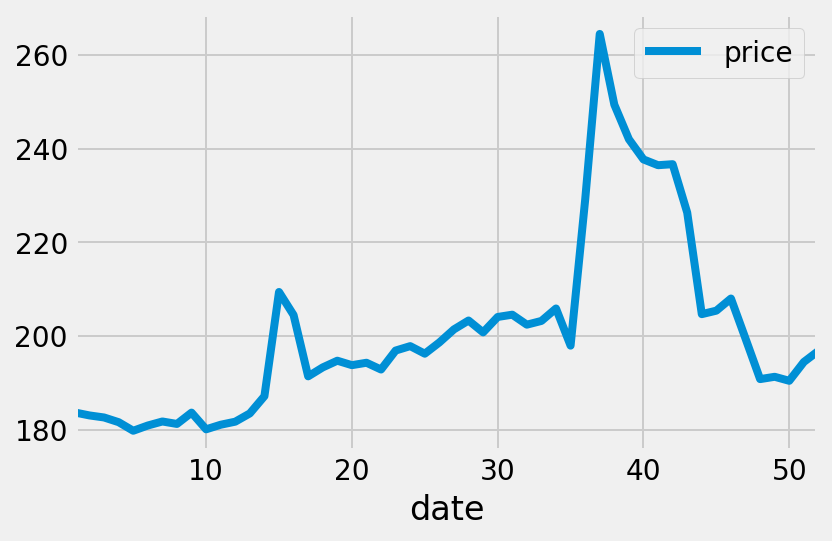

In [17]:
calendar_available.plot();
save_fig('BostonPrices')

We can easily see that the cheapest time to stay in Boston is during the first 12 weeks of the year. Interestingly there is a large jump in price at about week 35 that lasts till week 44.

## Does the time as a host make them less accepting?

#### Data preperation

In [18]:
# Creating a column of days as host. We will use the last booking date from the calander as the present date
listings['daysAsHost'] = (calendar.date.max() - listings.host_since)

In [19]:
# Pulling days from the series object
listings['daysAsHost'] = listings.daysAsHost.dt.days

In [20]:
# Transforming the acceptance rate.
listings['host_acceptance_rate'] = listings.host_acceptance_rate.str.replace('%', '')

In [21]:
# Filtering the data so we only have that with known acceptance date.
listings_days_acceptance = listings[listings.host_response_rate.notna()][['daysAsHost','host_acceptance_rate']]

In [22]:
listings_days_acceptance['host_acceptance_rate'] = listings_days_acceptance.host_acceptance_rate.astype(int)

##### Analysis

In [23]:
listings_days_acceptance.corr()

,daysAsHost,host_acceptance_rate
daysAsHost,1.000000,-0.172121
host_acceptance_rate,-0.172121,1.000000


We can see a negative corrolation between the days as a host and acceptance rate.

In [24]:
listings_days_acceptance.describe()

,daysAsHost,host_acceptance_rate
count,3114.000000,3114.000000
mean,1280.640655,84.173089
std,631.771793,21.779254
min,376.000000,0.000000
25%,829.000000,71.000000
50%,1139.000000,94.000000
75%,1625.000000,100.000000
max,3220.000000,100.000000


Here I am putting the data into buckets so that we can get a more detailed view of how time alters a hosts acceptability.

In [25]:
listings_days_acceptance.loc[listings_days_acceptance.daysAsHost < 829, ('host_days_bin')] = 'short'
listings_days_acceptance.loc[(listings_days_acceptance.daysAsHost >= 829) & (listings_days_acceptance.daysAsHost < 1139), ('host_days_bin')] = 'shortToMedium'
listings_days_acceptance.loc[(listings_days_acceptance.daysAsHost >= 1139) & (listings_days_acceptance.daysAsHost < 1625), ('host_days_bin')] = 'MediumToLong'
listings_days_acceptance.loc[(listings_days_acceptance.daysAsHost >= 1625), ('host_days_bin')] = 'Long'

In [26]:
listings_days_acceptance.groupby(['host_days_bin']).mean().style.background_gradient(cmap=cm)

,daysAsHost,host_acceptance_rate
host_days_bin,,
Long,2173.74,79.751
MediumToLong,1351.94,85.6224
short,608.302,88.7494
shortToMedium,976.479,82.6145


## What features lead to a higher prices?

#### Data preperation and analysis
Here I am going to go through each column that I have selected for the question and analysis it. I will also check for missing values and process the data so that it can be used in a linear model later on.

In [27]:
listings.price.sample(5, random_state=42)

3163    $160.00
3133    $135.00
937     $525.00
196     $114.00
2852     $55.00
Name: price, dtype: object

In [28]:
# removing string characters
listings['price'] = listings.price.str.replace('\$|,', '')
# changing type to float
listings['price'] = listings.price.astype(float)

Text(0.5,1,'Histogram of Price')

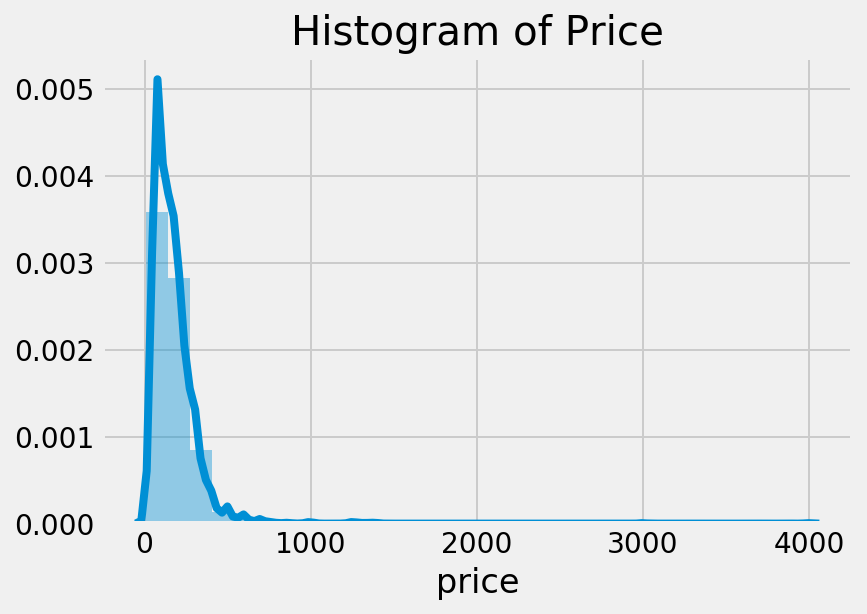

In [29]:
histplot(data=listings.price, bins=30, title='Histogram of Price')

In [30]:
# selecting out wanted columns
listings_selected = listings[['description',
          'host_response_time',
          'neighbourhood_cleansed',
          'property_type',
          'room_type',
          'accommodates',
          'bathrooms',
          'bedrooms',
          'beds',
          'bed_type',
          'price',
          'cleaning_fee',
          'minimum_nights',
          'maximum_nights']].copy()

There are a small number of outliers in the target data that are not representative of the bulk of the listings. As these will negatively affect the accuaracy of the model I will remove them from the data.

In [31]:
# removing outliers from the pricing
listings_selected = listings_selected[listings_selected.price < 1000]

### description_length

Alot could be gained from the description. Sentiment analysis could be a good engineered feature for helping answer the question as could be pulling out keywords that represent the property. As this would take a long amount of time I have decided to just use the length of the description as a feature.

In [32]:
#  Using description length as a feature
listings_selected['description_length'] = listings_selected.description.str.len()
listings_selected.drop(['description'], axis=1, inplace=True)

Saving figure description_length


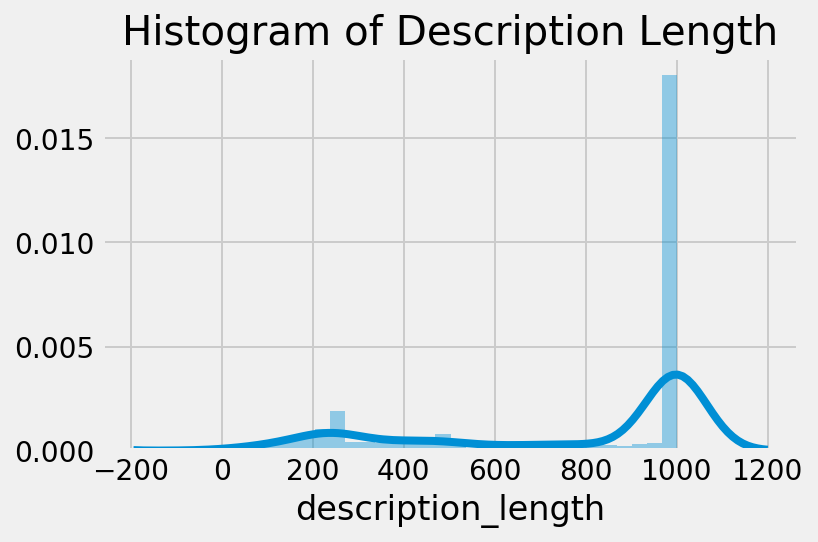

In [33]:
histplot(data=listings_selected.description_length, bins=30, title='Histogram of Description Length');
save_fig('description_length')

In [34]:
listings.description[1]

"Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am likely working in my home office, which is a separate room. I can help you settle in and give you tips and directions on the neighborhood and Boston.  The room is in Roslindale, a diverse and primarily residential neighborhood of Boston. It's well connected via public transportation to other neighborhoods and easy to access by car. Roslindale Square is a nice business district with supermarkets. banks, a bakery, etc. (See my Guidebook for some recommendations). The Arnold Arboretum is just steps away. Plenty of safe 

It looks as if the data is truncated. So I have decided to drop this column.

In [35]:
listings_selected.drop(['description_length'], axis=1, inplace=True)

### host_response_time
The length of time it take for a host to respond to the user could be a good indicator of how invested the host is in the property and in turn how much their service is worth.

In [36]:
listings.host_response_time.value_counts(dropna=False)

within an hour        1384
within a few hours    1218
NaN                    471
within a day           469
a few days or more      43
Name: host_response_time, dtype: int64

There seem to be 220 rows of data where we don't know the host_response_time. I am not going to remove this data for now as it may prove of use.

In [37]:
# adding the data to a list for categorical columns
cat_columns = ['host_response_time']

### neighbourhood_cleansed

There is a good chance that the properties location will have large affect on how much it will cost to stay.

In [38]:
listings_selected.neighbourhood_cleansed.value_counts(dropna=False)

Jamaica Plain              343
South End                  325
Back Bay                   301
Fenway                     287
Dorchester                 269
Allston                    260
Beacon Hill                192
Brighton                   185
South Boston               173
Downtown                   172
East Boston                150
North End                  143
Roxbury                    143
Mission Hill               124
Charlestown                110
South Boston Waterfront     81
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

There seems to be no missing elements of data but there is a unbalance in the areas.

In [39]:
cat_columns.append('neighbourhood_cleansed')

### property_type
Property type should have a big affect on the asking price.

In [40]:
listings_selected.property_type.value_counts(dropna=False)

Apartment          2602
House               560
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
NaN                   3
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

There seems to be a few missing values in the data. However there are so few of them there won't be much worth in keeping the row. For this reason I am going to drop these rows. I can also see that there are a few types that are hardly represented which may have a poor affect on our ability to predict for them.

In [41]:
# property_type has 2 elements that are missing. As this makes up such a small amount of the data I will drop these rows
listings_selected.dropna(subset=['property_type'], inplace=True)

In [42]:
cat_columns.append('property_type')

### room_type
Room type should have large affect on the price as a person would normally be more willing to pay more money for an entire home that just a room

In [43]:
listings_selected.room_type.value_counts(dropna=False)

Entire home/apt    2116
Private room       1374
Shared room          80
Name: room_type, dtype: int64

There looks to be no missing data but shared rooms are poorly represented compared to the other types.

In [44]:
cat_columns.append('room_type')

### accommodates
This column should have an affect on the price as the more poeple a place can house the more it should be worth.

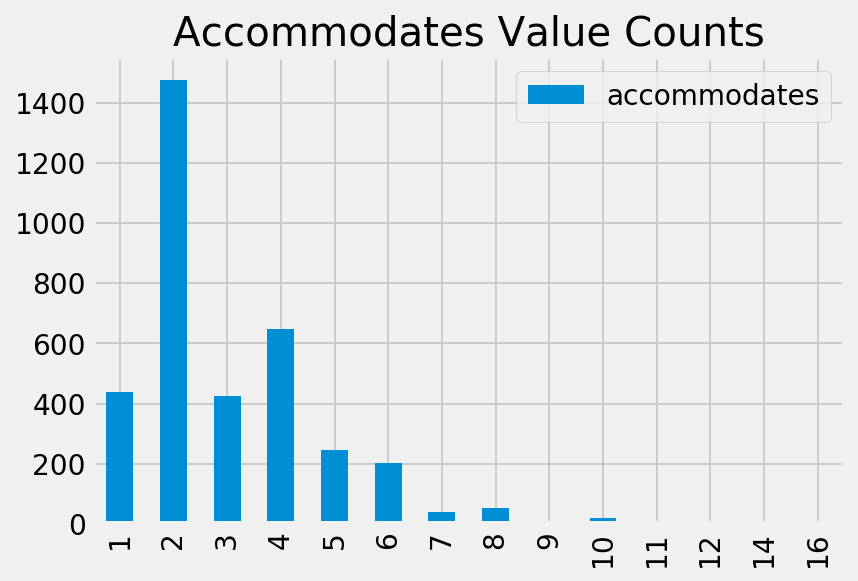

In [45]:
valueCountsBarPlot(listings_selected.accommodates, dropna=False, title='Accommodates Value Counts');

We can clearly see that 2 and 3 are the most popular values in the data. We can also see that there are no missing values and that there are a few outliers. These outliers could be removed but I will leave them for now.

### bathrooms
The number of bathrooms adds convenience to a property and should in turn add value.

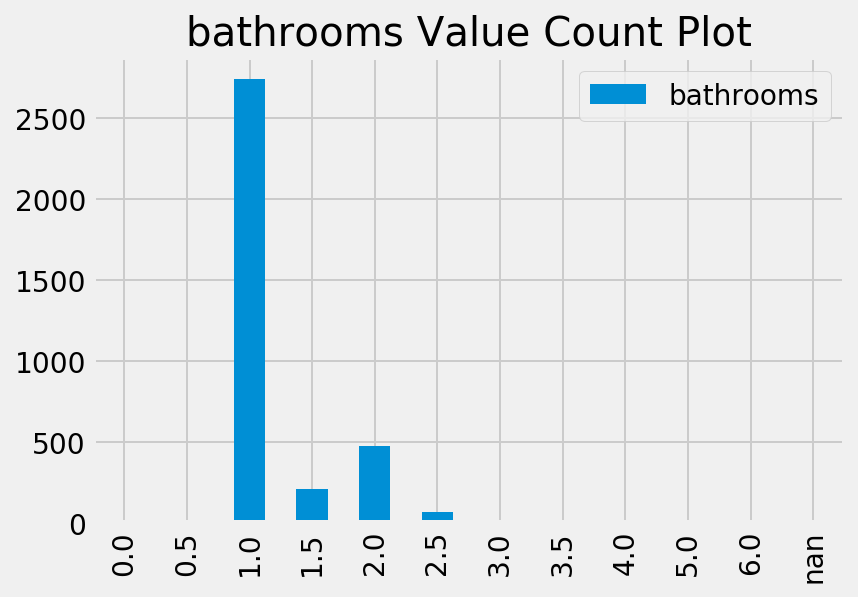

In [46]:
valueCountsBarPlot(listings_selected.bathrooms, dropna=False, title='bathrooms Value Count Plot');

I find this data odd as there are number of 1.5 bathrooms. This could mean that there is only a sink and toilet but no shower. There are also a very small number of missing values in this data. As they are so small I will choose to drop these rows.

In [47]:
# dropping rows where there is no bathroom number as there are so little of them in the data
listings_selected.dropna(subset=['bathrooms'], inplace=True)

### bedrooms
Separate bedrooms can be of use to many people wanting to use a place and in turn more people should add to the value

In [48]:
listings_selected.bedrooms.value_counts(dropna=False)

 1.0    2357
 2.0     690
 0.0     286
 3.0     153
 4.0      45
 5.0      15
NaN       10
Name: bedrooms, dtype: int64

There seem to be some rows with missing bedrooms. I will take a close look at these

In [49]:
listings_selected[listings_selected.bedrooms.isna()]

,host_response_time,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,minimum_nights,maximum_nights
918,within a day,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,176.0,NaN,1,1125
920,within a few hours,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,229.0,$75.00,2,120
924,within a few hours,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,275.0,NaN,3,730
1095,within a few hours,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,186.0,NaN,3,365
1117,within a few hours,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,269.0,NaN,3,365
1132,within a few hours,South End,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,225.0,NaN,3,365
1251,within a few hours,Back Bay,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,209.0,NaN,2,365
1366,within a few hours,Back Bay,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,209.0,NaN,2,120
1419,within a few hours,Back Bay,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,209.0,NaN,2,120
1959,within an hour,Beacon Hill,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,175.0,$50.00,4,365


These all seem to have be Apartments where the person has the entire home and there is one bed. I am going to assume that there is either not a bedroom for the bed or the user has not entered the data correctly. For these I am just going to fill the missing values with 1 as it is the median of the data.

In [50]:
listings_selected['bedrooms'] = listings_selected.bedrooms.fillna(1)

### beds
A greater number of beds should mean more people can stay at a place and should add to the value of the property.

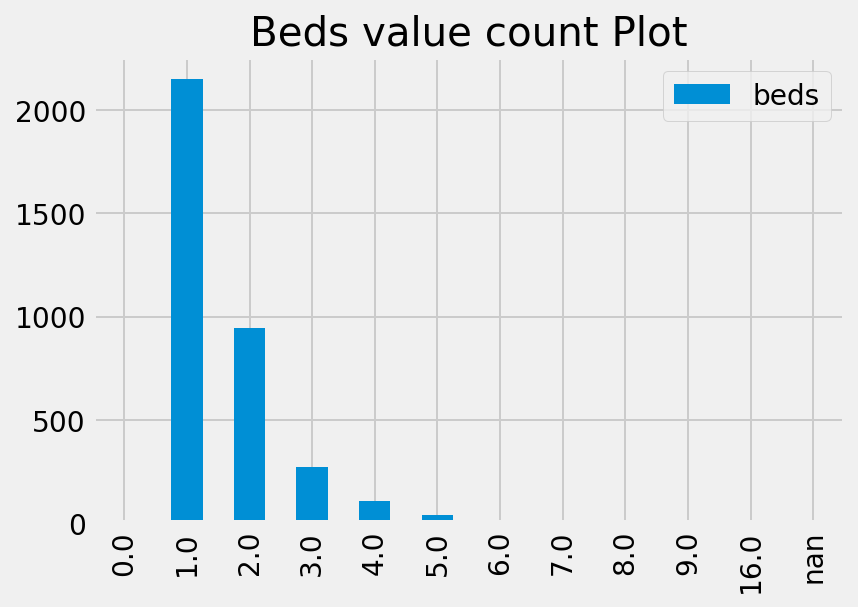

In [51]:
valueCountsBarPlot(listings_selected.beds, dropna=False, title='Beds value count Plot');

In [52]:
# drop rows of missing bed data as there are so few of them
listings_selected.dropna(subset=['beds'], inplace=True)

### bed_type
It should go without saying that it is nicer to sleep on a real bed than a couch so the bed type should alter the price that is being asked for.

In [53]:
listings_selected.bed_type.value_counts(dropna=False)

Real Bed         3420
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64

In [54]:
cat_columns.append('bed_type')

### cleaning_fee
This columns might be corrolated with the price as bigger more expensive properties might have bigger cleaning bills. Howver this charge might also be taken into account by the final price so might not be indepent.

In [55]:
listings_selected.cleaning_fee.value_counts(dropna=False).head()

NaN        1091
$100.00     350
$50.00      325
$25.00      210
$20.00      135
Name: cleaning_fee, dtype: int64

I am assuming that if there if the cleaning fee is nan then it is not applicable and will fill with 0

In [56]:
# changing data so that it can be used as as float
listings_selected['cleaning_fee'] = listings_selected.cleaning_fee.str.replace('\$|,', '')

In [57]:
listings_selected['cleaning_fee'] = listings_selected.cleaning_fee.fillna(0)

In [58]:
listings_selected['cleaning_fee'] = listings_selected.cleaning_fee.astype(float)

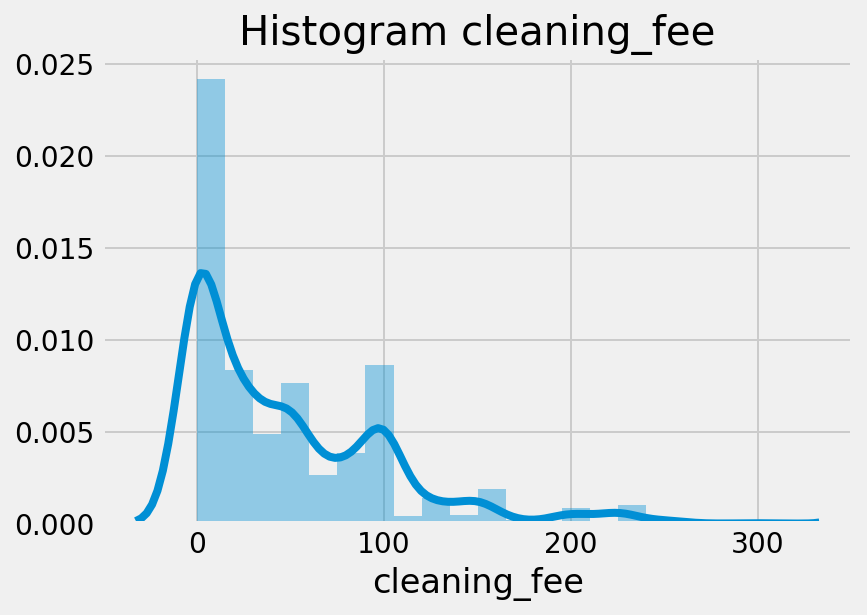

In [59]:
histplot(listings_selected.cleaning_fee, bins=20, title='Histogram cleaning_fee');

### minimum_nights
The flexability of how long a person has to stay at a property might be reflected in the asked price. When staying at a place for a long time a lower price might be asked for.

In [60]:
# checking for missing data
listings_selected.minimum_nights.isna().any()

False

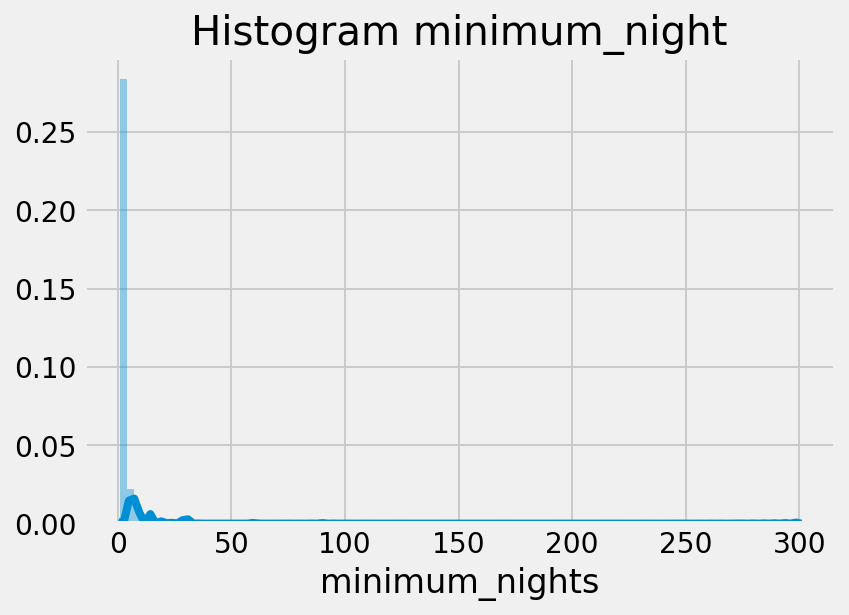

In [61]:
histplot(listings_selected.minimum_nights, bins=100, title='Histogram minimum_night');

This shows that there are some extreme outliers in the data. These might need to be removed as they may badly affect our model.

In [62]:
listings_selected[listings_selected.minimum_nights > 50]

,host_response_time,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,minimum_nights,maximum_nights
59,NaN,Jamaica Plain,Bed & Breakfast,Private room,2,1.0,1.0,1.0,Real Bed,55.0,0.0,300,365
1243,within a day,Back Bay,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,110.0,150.0,60,365
1344,within a day,Back Bay,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,99.0,150.0,90,365
1416,within a day,Back Bay,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,130.0,150.0,60,365
1526,within a day,Back Bay,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,130.0,150.0,60,365
2195,a few days or more,Fenway,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,45.0,35.0,90,1125
2635,NaN,Brighton,Apartment,Entire home/apt,5,2.0,3.0,4.0,Real Bed,135.0,180.0,60,180
3475,within an hour,Allston,House,Private room,1,1.5,1.0,1.0,Real Bed,58.0,50.0,273,364


### maximum_nights
This could show if a owner wants a quicker turn over for a property. How this might affect the price I don't know but will include it to find out.

In [63]:
# checking for missing data
listings_selected.maximum_nights.isna().any()

False

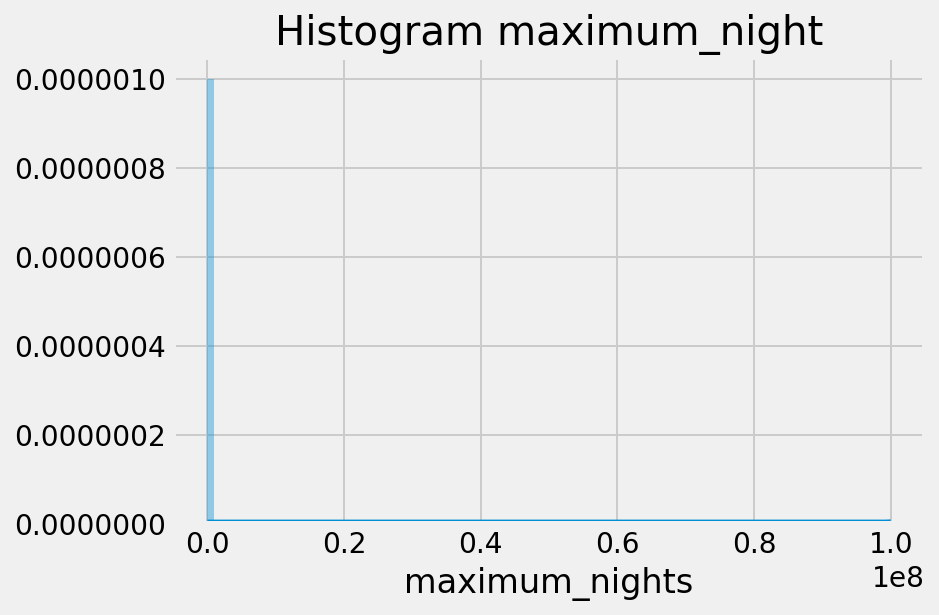

In [64]:
histplot(listings_selected.maximum_nights, bins=100, title='Histogram maximum_night');

There are again some outliers in the data that probably should be removed

In [65]:
listings_selected[listings_selected.maximum_nights > 1825]

,host_response_time,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,minimum_nights,maximum_nights
697,within an hour,North End,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,125.0,45.0,1,99999999
902,within a day,Roxbury,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,35.0,50.0,30,2000
1649,within an hour,East Boston,House,Private room,1,1.0,1.0,1.0,Real Bed,80.0,100.0,7,9999


While looking through the data we have seen many categorical columns that need to be processed to numeric ones so that they can be used in the linear model. The below function will take the data and make the columns for us.

In [66]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [67]:
cat_columns

['host_response_time',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [68]:
listings_dummied = create_dummy_df(listings_selected, cat_cols=cat_columns, dummy_na=True)

In [69]:
# create our features and labels data
X = listings_dummied.drop(['price'],axis=1)
y = listings_dummied['price']

In [70]:
# spliting our data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
model = LinearRegression(normalize=True, n_jobs=-1)

In [72]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [73]:
train_pred = model.predict(X_train)

In [74]:
np.sqrt(mean_squared_error(y_train, train_pred))

74.9688094804514

In [75]:
r2_score(y_train, train_pred)

0.5561684785500414

The r2 score shows that 55% of the variance can be explained by our model.

In [76]:
test_pred = model.predict(X_test)

In [77]:
np.sqrt(mean_squared_error(y_test, test_pred))

68.68548460345951

In [78]:
r2_score(y_test, test_pred)

0.604017295847571

In [79]:
# extracting the coefficients into a DataFrame and transposing them
coefs = pd.DataFrame(model.coef_).T

# creating a list of the features used and using them for the coefficients
coefs.columns = list(X_train)

# Transposing the DataFrame so that it is easier to fit on screen
coefs = coefs.T

# alter column name so that it is more clear
coefs.columns = ['coefs']

# sorting the values to be in ascending order
coefs.sort_values(['coefs'], inplace=True)

# resetting the index so that we can slice the data
coefs.reset_index(inplace=True)

# altering the columns names again
coefs.columns = ['feature','coefs']

In [80]:
coefs[coefs.feature.str.startswith('neighbourhood_cleansed')].style.background_gradient(cmap=cm)

,feature,coefs
0,neighbourhood_cleansed_nan,-7.59607e+15
10,neighbourhood_cleansed_Hyde Park,-26.4291
11,neighbourhood_cleansed_Roslindale,-22.199
12,neighbourhood_cleansed_Dorchester,-20.0007
13,neighbourhood_cleansed_West Roxbury,-18.6087
14,neighbourhood_cleansed_Mattapan,-18.5149
17,neighbourhood_cleansed_East Boston,-5.72302
25,neighbourhood_cleansed_Jamaica Plain,3.6083
26,neighbourhood_cleansed_Brighton,4.47979
35,neighbourhood_cleansed_Roxbury,17.6362


In [81]:
coefs[coefs.feature.str.startswith('property_type')].style.background_gradient(cmap=cm)

,feature,coefs
1,property_type_Camper/RV,-145.535
7,property_type_Dorm,-37.053
9,property_type_Entire Floor,-27.3656
20,property_type_nan,0
29,property_type_Guesthouse,5.64491
30,property_type_House,6.03005
31,property_type_Loft,11.5022
33,property_type_Condominium,13.7519
38,property_type_Townhouse,25.3214
39,property_type_Villa,26.5192


In [82]:
coefs[coefs.feature.str.startswith('host_response_time')].style.background_gradient(cmap=cm)

,feature,coefs
4,host_response_time_within a day,-52.8449
5,host_response_time_within an hour,-48.5498
6,host_response_time_within a few hours,-38.0568
8,host_response_time_nan,-33.3845


In [83]:
coefs[coefs.feature.str.startswith('room_type')].style.background_gradient(cmap=cm)

,feature,coefs
2,room_type_Private room,-55.4607
3,room_type_Shared room,-54.7755
21,room_type_nan,0


In [84]:
coefs[coefs.feature.str.startswith('bed_type')].style.background_gradient(cmap=cm)

,feature,coefs
15,bed_type_Couch,-10.6752
16,bed_type_Pull-out Sofa,-6.86999
22,bed_type_nan,0
24,bed_type_Futon,1.23807
32,bed_type_Real Bed,12.3974


In [85]:
coefs[coefs.feature.isin(['accommodates','bathrooms','bedrooms','beds','cleaning_fee','minimum_nights','maximum_nights'])].style.background_gradient(cmap=cm)

,feature,coefs
18,minimum_nights,-0.609662
19,maximum_nights,-4.77946e-07
23,cleaning_fee,0.114095
27,beds,4.81654
28,accommodates,5.55286
34,bathrooms,16.7854
43,bedrooms,44.4877
